# CREDIT SCORING

----

In [201]:
!wget -O german_credit_data.csv https://raw.githubusercontent.com/selva86/datasets/master/GermanCredit.csv


--2025-09-18 16:49:35--  https://raw.githubusercontent.com/selva86/datasets/master/GermanCredit.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 250919 (245K) [text/plain]
Saving to: ‘german_credit_data.csv’

german_credit_data. 100%[===================>] 245.04K  --.-KB/s    in 0.02s   

2025-09-18 16:49:35 (10.5 MB/s) - ‘german_credit_data.csv’ saved [250919/250919]



----

----

In [202]:
# Import the libraries

In [203]:
import os

In [204]:
import json

In [205]:
import warnings

In [206]:
warnings.filterwarnings("ignore")

In [207]:
import numpy as np

In [208]:
import pandas as pd

In [209]:
import matplotlib.pyplot as plt

In [210]:
import seaborn as sns

In [211]:
from collections import Counter

In [212]:
# sklearn imports

In [213]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

In [214]:
from sklearn.pipeline import Pipeline

In [215]:
from sklearn.compose import ColumnTransformer

In [216]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [217]:
from sklearn.linear_model import LogisticRegression

In [218]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, classification_report

In [219]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [220]:
from sklearn.calibration import CalibratedClassifierCV

In [221]:
import joblib

------

--------

In [222]:
# Dataset


In [223]:
!wget -O german_credit_data.csv https://raw.githubusercontent.com/selva86/datasets/master/GermanCredit.csv

--2025-09-18 16:49:35--  https://raw.githubusercontent.com/selva86/datasets/master/GermanCredit.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 250919 (245K) [text/plain]
Saving to: ‘german_credit_data.csv’

german_credit_data. 100%[===================>] 245.04K  --.-KB/s    in 0.02s   

2025-09-18 16:49:35 (11.0 MB/s) - ‘german_credit_data.csv’ saved [250919/250919]



In [224]:
CSV_PATH = "german_credit_data.csv"

In [225]:
MODEL_PATH = "model.joblib"

In [226]:
FEATURES_PATH = "feature_columns.json"

-----

-----

In [227]:
# Load dataset

In [228]:
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"CSV file not found: {CSV_PATH}. Please place it in the working directory.")

In [229]:
df = pd.read_csv(CSV_PATH)

In [230]:
print(f"Loaded file: {CSV_PATH}, Shape: {df.shape}\n")

Loaded file: german_credit_data.csv, Shape: (1000, 21)



In [231]:
# Preview

In [232]:
print("First 5 rows:")
print(df.head(), "\n")

First 5 rows:
                status  duration                            credit_history  \
0         ... < 100 DM         6   critical account/other credits existing   
1    0 <= ... < 200 DM        48  existing credits paid back duly till now   
2  no checking account        12   critical account/other credits existing   
3         ... < 100 DM        42  existing credits paid back duly till now   
4         ... < 100 DM        24           delay in paying off in the past   

               purpose  amount                     savings  \
0  domestic appliances    1169  unknown/no savings account   
1  domestic appliances    5951                ... < 100 DM   
2           retraining    2096                ... < 100 DM   
3     radio/television    7882                ... < 100 DM   
4            car (new)    4870                ... < 100 DM   

  employment_duration  installment_rate                  personal_status_sex  \
0      ... >= 7 years                 4                        m

In [233]:
print("Column names:", list(df.columns), "\n")

Column names: ['status', 'duration', 'credit_history', 'purpose', 'amount', 'savings', 'employment_duration', 'installment_rate', 'personal_status_sex', 'other_debtors', 'present_residence', 'property', 'age', 'other_installment_plans', 'housing', 'number_credits', 'job', 'people_liable', 'telephone', 'foreign_worker', 'credit_risk'] 



In [234]:
print("Dtypes:")
print(df.dtypes, "\n")

Dtypes:
status                     object
duration                    int64
credit_history             object
purpose                    object
amount                      int64
savings                    object
employment_duration        object
installment_rate            int64
personal_status_sex        object
other_debtors              object
present_residence           int64
property                   object
age                         int64
other_installment_plans    object
housing                    object
number_credits              int64
job                        object
people_liable               int64
telephone                  object
foreign_worker             object
credit_risk                 int64
dtype: object 



In [235]:
print(f"Memory usage (MB): {round(df.memory_usage(deep=True).sum() / 1024**2,3)}\n")

Memory usage (MB): 0.851



In [236]:
print("Missing values per column:")
print(df.isnull().sum(), "\n")

Missing values per column:
status                     0
duration                   0
credit_history             0
purpose                    0
amount                     0
savings                    0
employment_duration        0
installment_rate           0
personal_status_sex        0
other_debtors              0
present_residence          0
property                   0
age                        0
other_installment_plans    0
housing                    0
number_credits             0
job                        0
people_liable              0
telephone                  0
foreign_worker             0
credit_risk                0
dtype: int64 



In [237]:
print("Number of duplicate rows:", df.duplicated().sum(), "\n")

Number of duplicate rows: 0 



--------

-----

In [238]:
#  Detect target column

In [239]:
possible_targets = ["Risk", "risk", "class", "Class", "credit_risk", "Creditability", "Creditability.1", "creditability"]


In [240]:
target_col = None

In [241]:
for c in possible_targets:
    if c in df.columns:
        target_col = c
        break
if target_col is None:
    last_col = df.columns[-1]
    uniq = df[last_col].dropna().unique()
    if len(uniq) <= 3:
        target_col = last_col
if target_col is None:
    raise ValueError("Could not auto-detect target column. Please set target manually.")

In [242]:
print("Using target column:", target_col)

Using target column: credit_risk


In [243]:
print("Target value counts:")
print(df[target_col].value_counts(dropna=False), "\n")

Target value counts:
credit_risk
1    700
0    300
Name: count, dtype: int64 



----

-----

In [244]:
#  Map target to 0/1

In [245]:
y_raw = df[target_col]

In [246]:
def map_target(y):
    uniq = pd.Series(y.dropna().unique()).astype(str).str.strip().str.lower().tolist()
    if set(uniq) <= {"good","1"}:
        return y.apply(lambda v: 1 if str(v).strip().lower() in ["good","1"] else 0)
    if set(uniq) <= {"bad","0"}:
        return y.apply(lambda v: 1 if str(v).strip().lower() in ["good","1"] else 0)
    try:
        uniq_nums = [int(float(u)) for u in uniq]
        if set(uniq_nums) <= {1,2}:
            return y.apply(lambda v: 1 if int(float(v))==1 else 0)
    except: pass
    most_common = y.mode().iloc[0]
    print("Warning: unknown target labels", uniq, "- mapping most common value to 1.")
    return y.apply(lambda v: 1 if v==most_common else 0)

In [247]:
y = map_target(y_raw)

In [248]:
df[target_col+"_mapped"] = y

In [249]:
print("Mapped target distribution (1 = likely creditworthy):")
print(y.value_counts(), "\n")

Mapped target distribution (1 = likely creditworthy):
credit_risk
1    700
0    300
Name: count, dtype: int64 



-----

--------

In [250]:
# Feature type correction

In [251]:
obj_cols = df.select_dtypes(include=["object"]).columns.tolist()

In [252]:
coerced = []

In [253]:
for c in obj_cols:
    if c == target_col: continue
    ser = df[c].dropna()
    conv = pd.to_numeric(ser, errors="coerce")
    if conv.notnull().sum() / len(ser) > 0.9:
        df[c] = pd.to_numeric(df[c], errors="coerce")
        coerced.append(c)

In [254]:
if coerced: print("Coerced object columns to numeric:", coerced, "\n")

----

-----

In [255]:
# Feature split

In [256]:
all_feature_cols = [c for c in df.columns if c not in [target_col, target_col+"_mapped"]]

In [257]:
num_cols = df[all_feature_cols].select_dtypes(include=[np.number]).columns.tolist()

In [258]:
cat_cols = [c for c in all_feature_cols if c not in num_cols]

In [259]:
print(f"Numeric cols ({len(num_cols)}): {num_cols}")

Numeric cols (7): ['duration', 'amount', 'installment_rate', 'present_residence', 'age', 'number_credits', 'people_liable']


In [260]:
print(f"Categorical cols ({len(cat_cols)}): {cat_cols}\n")

Categorical cols (13): ['status', 'credit_history', 'purpose', 'savings', 'employment_duration', 'personal_status_sex', 'other_debtors', 'property', 'other_installment_plans', 'housing', 'job', 'telephone', 'foreign_worker']



----

----

In [261]:
# EDA with Visualizations

In [262]:
# Numeric distributions

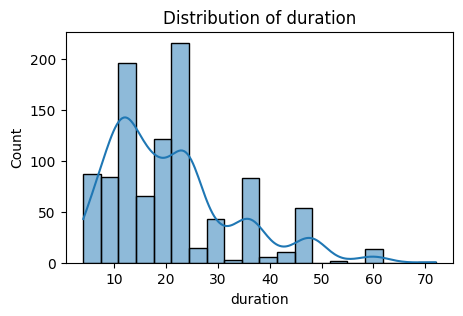

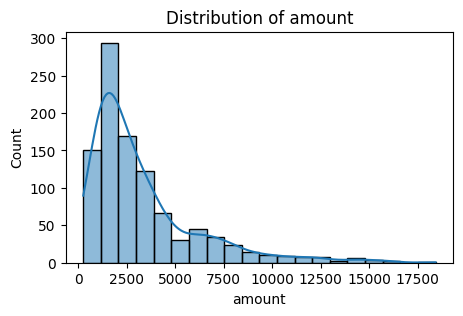

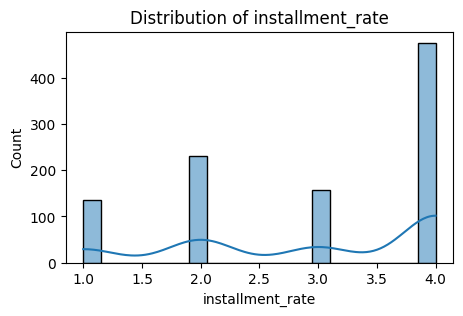

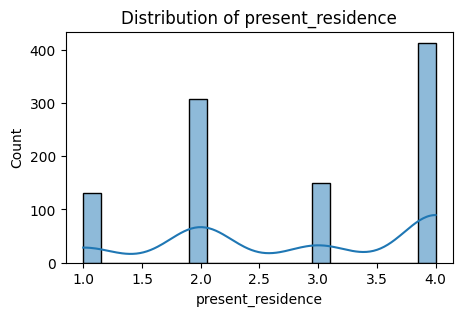

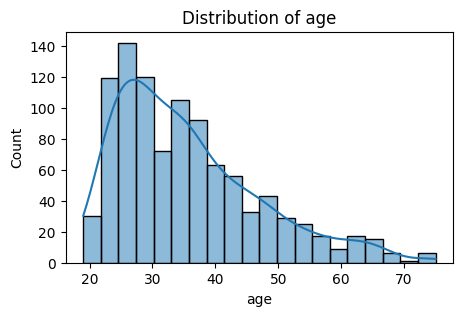

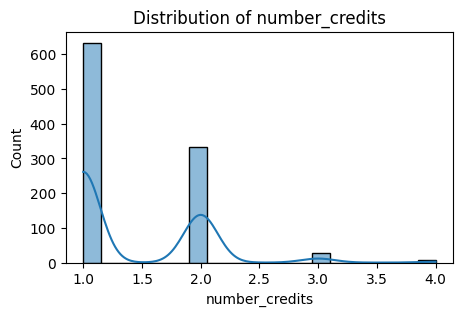

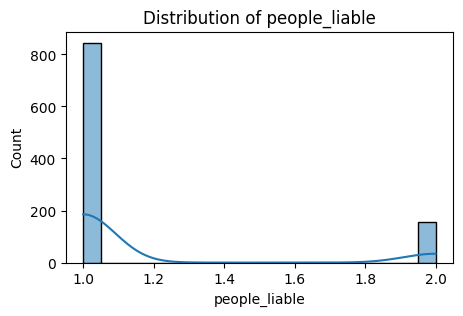

In [263]:
for c in num_cols:
    plt.figure(figsize=(5,3))
    sns.histplot(df[c], kde=True, bins=20)
    plt.title(f"Distribution of {c}")
    plt.show()

In [264]:
# Boxplots for outliers

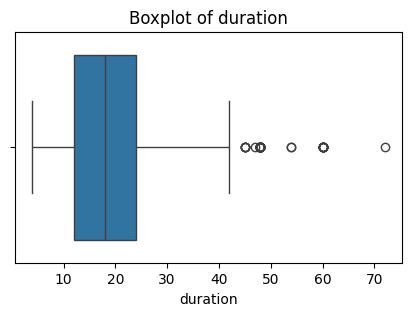

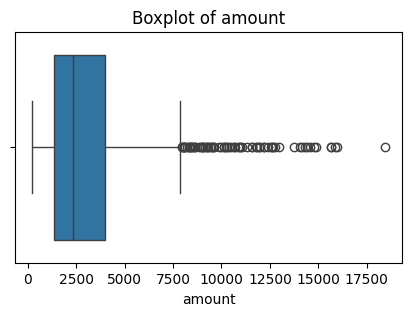

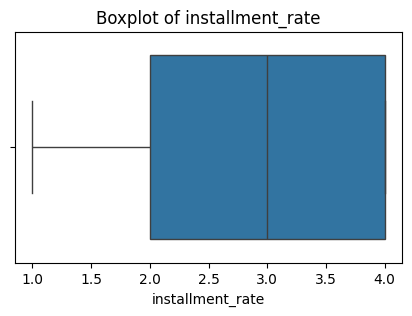

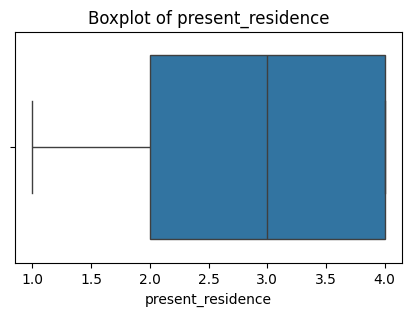

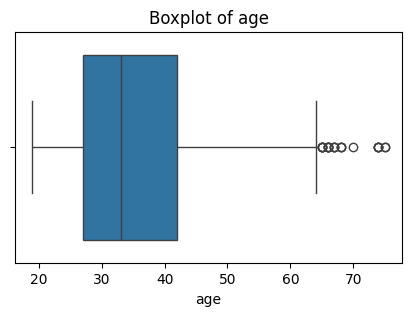

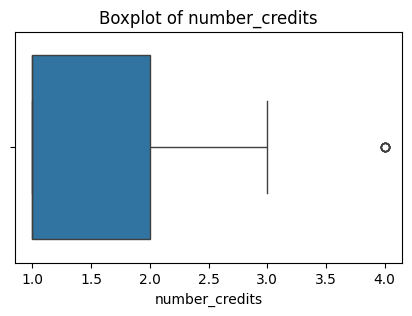

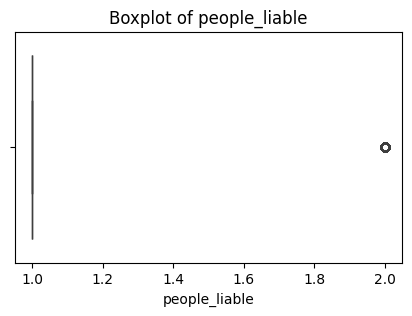

In [265]:
for c in num_cols:
    plt.figure(figsize=(5,3))
    sns.boxplot(x=df[c])
    plt.title(f"Boxplot of {c}")
    plt.show()

In [266]:
# Categorical value counts

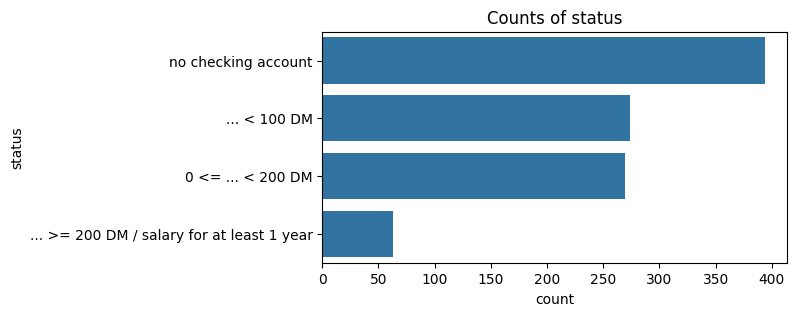

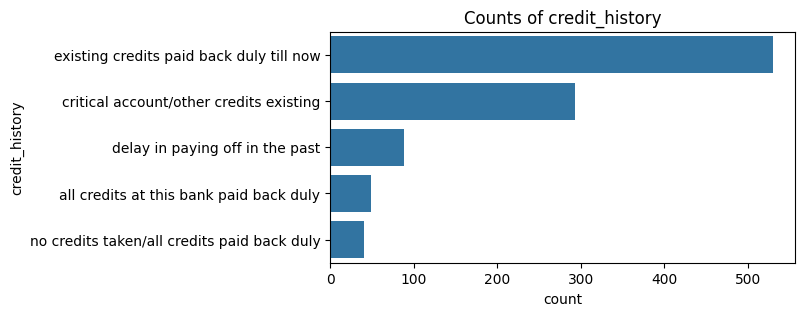

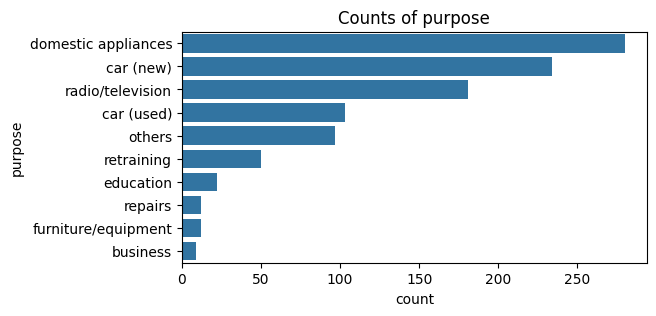

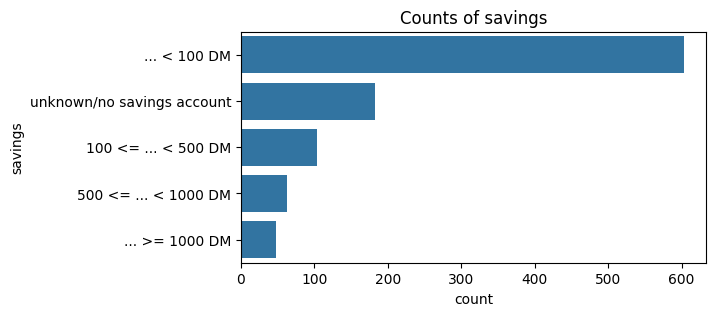

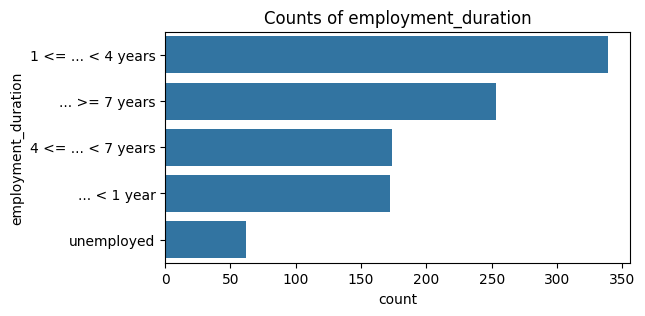

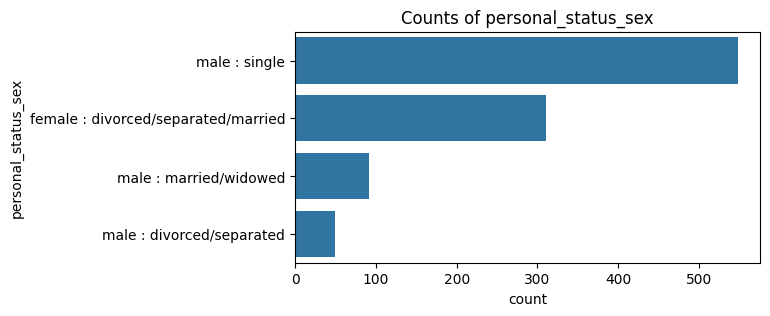

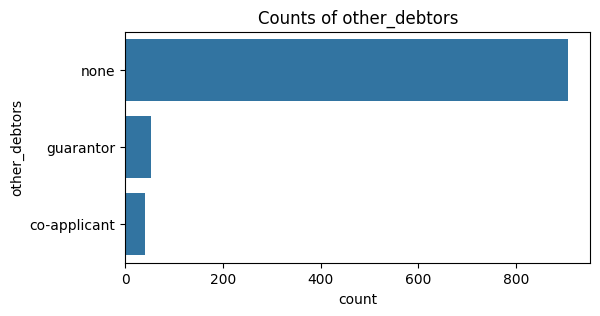

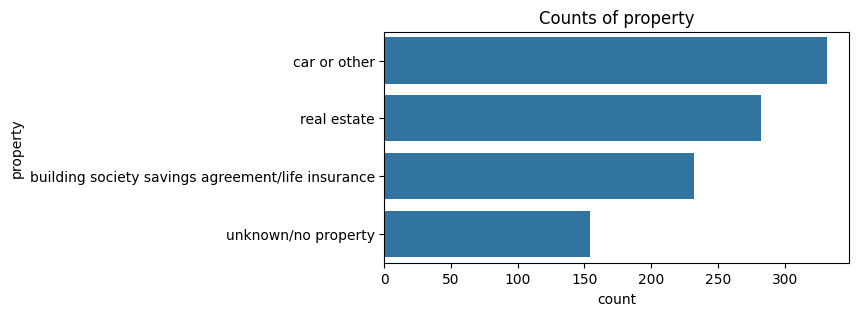

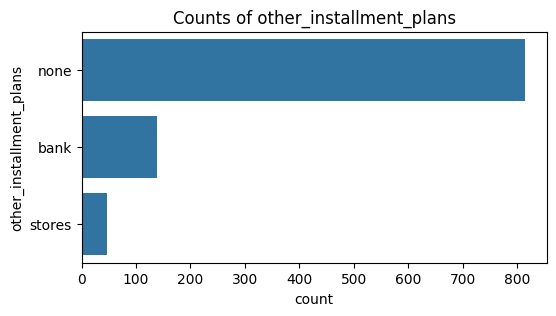

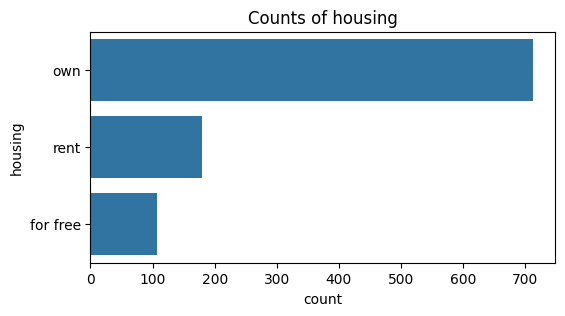

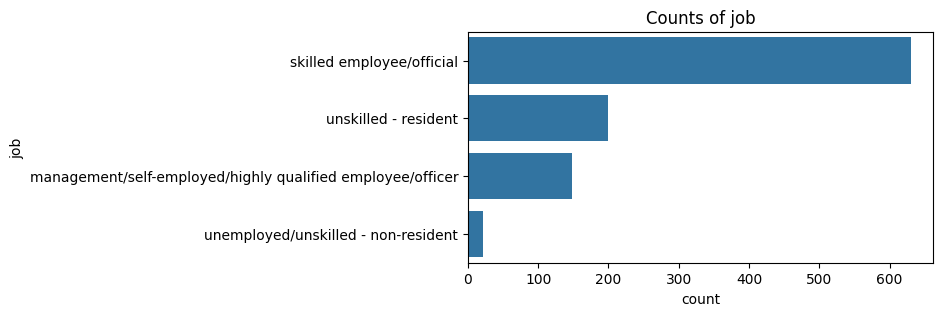

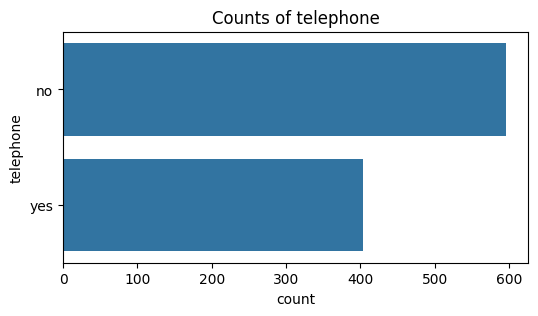

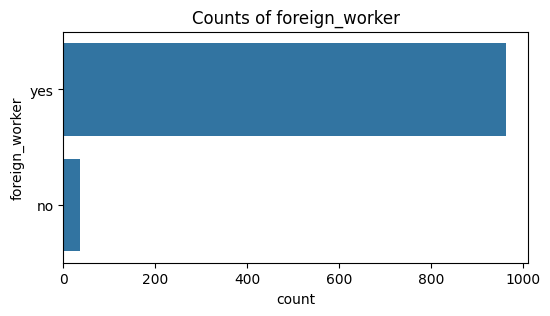

In [267]:
for c in cat_cols:
    plt.figure(figsize=(6,3))
    sns.countplot(y=df[c], order=df[c].value_counts().index)
    plt.title(f"Counts of {c}")
    plt.show()

In [268]:
# Correlation heatmap for numeric

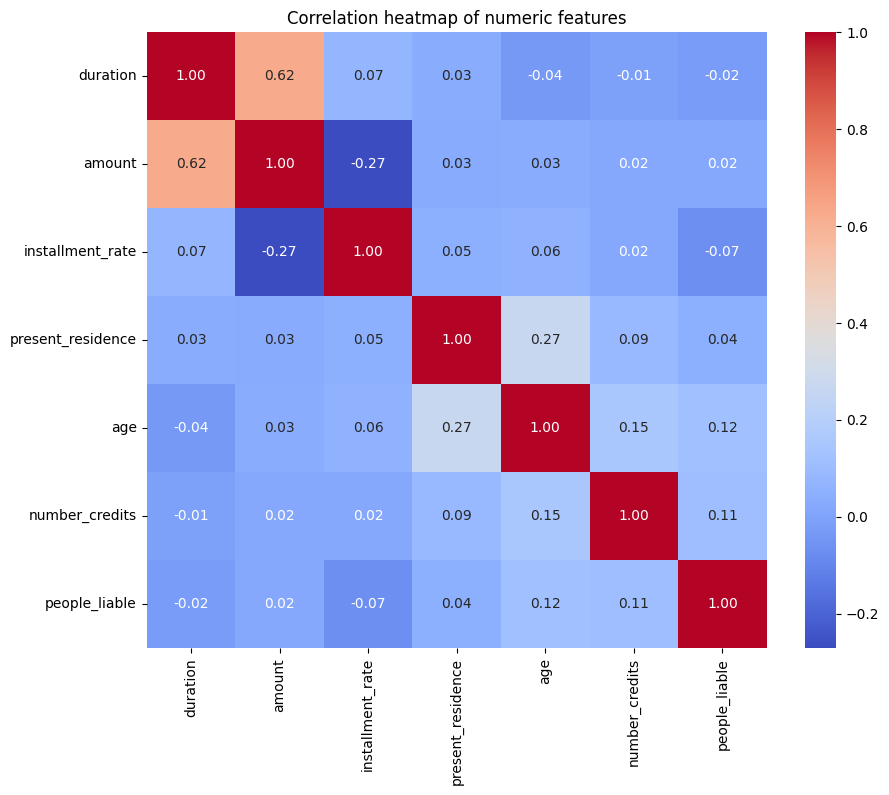

In [269]:
plt.figure(figsize=(10,8))
sns.heatmap(df[num_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation heatmap of numeric features")
plt.show()

------

-----

In [270]:
#  Train/Test Split

In [271]:
X = df[all_feature_cols].copy()

In [272]:
y = df[target_col+"_mapped"].astype(int).copy()

In [273]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [274]:
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (800, 20) Test shape: (200, 20)


In [275]:
print("Train target distribution:")
print(y_train.value_counts(normalize=True), "\n")

Train target distribution:
credit_risk_mapped
1    0.7
0    0.3
Name: proportion, dtype: float64 



-----

------

In [276]:
# Preprocessing Pipeline

In [277]:
ohe_kwargs = {"handle_unknown":"ignore"}

In [278]:
try: ohe_kwargs["sparse_output"]=False
except: ohe_kwargs["sparse"]=False

In [279]:
numeric_transformer = Pipeline([("scaler", StandardScaler())])

In [280]:
categorical_transformer = Pipeline([("onehot", OneHotEncoder(**ohe_kwargs))])

In [281]:
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols)
], remainder="drop")

----

----

In [282]:
# Model Pipeline

In [283]:
clf = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000, solver="liblinear", random_state=42))
])

In [284]:
param_grid = {
    "classifier__C":[0.01,0.1,1,10],
    "classifier__penalty":["l1","l2"],
    "classifier__class_weight":[None,"balanced"]
}

In [285]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [286]:
grid = GridSearchCV(clf, param_grid, scoring="roc_auc", cv=cv, n_jobs=-1, verbose=1)

In [287]:
print("Starting GridSearchCV...")
grid.fit(X_train, y_train)

Starting GridSearchCV...
Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['duration',
                                                                          'amount',
                                                                          'installment_rate',
                                                                          'present_residence',
                                                                          'age',
                                                                          'number_credits',
                                                                          'people_liable']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(ha...
                                                                          'other_debtors',
                                                                          'property',
                                                                          'other_installment_plans',
                                                                          'housing',
                                                                          'job',
                                                                          'telephone',
                                                                          'foreign_worker'])])),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.01, 0.1, 1, 10],
                         'classifier__class_weight': [None, 'balanced'],
                         'classifier__penalty': ['l1', 'l2']},
             scoring='roc_auc', verbose=1)

In [288]:
print("Best params:", grid.best_params_)

Best params: {'classifier__C': 0.1, 'classifier__class_weight': None, 'classifier__penalty': 'l2'}


In [289]:
print("Best CV ROC AUC:", grid.best_score_, "\n")

Best CV ROC AUC: 0.7920758928571427 



-----

------

In [290]:
# Evaluation

In [291]:
best = grid.best_estimator_

In [292]:
y_proba = best.predict_proba(X_test)[:,1]

In [293]:
y_pred = (y_proba>=0.5).astype(int)

In [294]:
roc = roc_auc_score(y_test, y_proba)

In [295]:
precision, recall, _ = precision_recall_curve(y_test, y_proba)

In [296]:
pr_auc = auc(recall, precision)

In [297]:
print(f"Test ROC AUC: {roc}, PR AUC: {pr_auc}")
print("Accuracy:", accuracy_score(y_test,y_pred))
print("Precision:", precision_score(y_test,y_pred))
print("Recall:", recall_score(y_test,y_pred))
print("F1:", f1_score(y_test,y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test,y_pred))
print("Classification report:\n", classification_report(y_test,y_pred))

Test ROC AUC: 0.7753571428571427, PR AUC: 0.8842743906361348
Accuracy: 0.74
Precision: 0.7972972972972973
Recall: 0.8428571428571429
F1: 0.8194444444444444
Confusion matrix:
 [[ 30  30]
 [ 22 118]]
Classification report:
               precision    recall  f1-score   support

           0       0.58      0.50      0.54        60
           1       0.80      0.84      0.82       140

    accuracy                           0.74       200
   macro avg       0.69      0.67      0.68       200
weighted avg       0.73      0.74      0.73       200



-----

-----

In [298]:
# Probability Calibration

In [299]:
calib = CalibratedClassifierCV(best, cv=5, method="sigmoid")

In [300]:
calib.fit(X_train, y_train)

CalibratedClassifierCV(cv=5,
                       estimator=Pipeline(steps=[('preprocessor',
                                                  ColumnTransformer(transformers=[('num',
                                                                                   Pipeline(steps=[('scaler',
                                                                                                    StandardScaler())]),
                                                                                   ['duration',
                                                                                    'amount',
                                                                                    'installment_rate',
                                                                                    'present_residence',
                                                                                    'age',
                                                                                    'number_credits',
                                                                                    'people_liable']),
                                                                                  ('cat',
                                                                                   Pipeline(steps=[('onehot',
                                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                                  sparse_output=False))]),
                                                                                   ['status',
                                                                                    'credit_history',
                                                                                    'purpose',
                                                                                    'savings',
                                                                                    'employment_duration',
                                                                                    'personal_status_sex',
                                                                                    'other_debtors',
                                                                                    'property',
                                                                                    'other_installment_plans',
                                                                                    'housing',
                                                                                    'job',
                                                                                    'telephone',
                                                                                    'foreign_worker'])])),
                                                 ('classifier',
                                                  LogisticRegression(C=0.1,
                                                                     max_iter=1000,
                                                                     random_state=42,
                                                                     solver='liblinear'))]))

In [301]:
y_proba_cal = calib.predict_proba(X_test)[:,1]

In [302]:
y_pred_cal = (y_proba_cal>=0.5).astype(int)

In [303]:
roc_cal = roc_auc_score(y_test,y_proba_cal)

In [304]:
precision_cal, recall_cal, _ = precision_recall_curve(y_test,y_proba_cal)

In [305]:
pr_auc_cal = auc(recall_cal, precision_cal)

In [306]:
print(f"Calibrated Test ROC AUC: {roc_cal}, PR AUC: {pr_auc_cal}")
print("Calibrated Accuracy:", accuracy_score(y_test,y_pred_cal))
print("Calibrated Precision:", precision_score(y_test,y_pred_cal))
print("Calibrated Recall:", recall_score(y_test,y_pred_cal))
print("Calibrated F1:", f1_score(y_test,y_pred_cal))
print("Calibrated Confusion matrix:\n", confusion_matrix(y_test,y_pred_cal))

Calibrated Test ROC AUC: 0.776904761904762, PR AUC: 0.8849425775743403
Calibrated Accuracy: 0.745
Calibrated Precision: 0.8027210884353742
Calibrated Recall: 0.8428571428571429
Calibrated F1: 0.8222996515679443
Calibrated Confusion matrix:
 [[ 31  29]
 [ 22 118]]


----

----

In [307]:
# Save Model and Features

In [308]:
joblib.dump(calib, MODEL_PATH)

['model.joblib']

In [309]:
with open(FEATURES_PATH, "w") as f: json.dump(list(X.columns), f)

In [310]:
print(f"\nSaved calibrated model to {MODEL_PATH} and feature columns to {FEATURES_PATH}")


Saved calibrated model to model.joblib and feature columns to feature_columns.json


-----

----

In [311]:
#  Sample Predictions

In [312]:
sample = X_test.iloc[:5].copy()

In [313]:
sample_proba = calib.predict_proba(sample)[:,1]

In [314]:
sample_pred = (sample_proba>=0.5).astype(int)

In [315]:
print("\nSample predictions (first 5 rows of test set):")
for i,(p,pr) in enumerate(zip(sample_pred,sample_proba)):
    print(f"Row {i} pred_label: {int(p)}, prob: {float(pr)}")


Sample predictions (first 5 rows of test set):
Row 0 pred_label: 1, prob: 0.7535387251877246
Row 1 pred_label: 0, prob: 0.22651823592694004
Row 2 pred_label: 0, prob: 0.446086665663237
Row 3 pred_label: 1, prob: 0.8350751437965673
Row 4 pred_label: 0, prob: 0.4487186812307664


------

# END